In [72]:
!pip install eto
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import bmi_PET
from fao_pet import ETRCalculator

# 1. Run Normal CFE Simulations

In [73]:
cfe_instance = bmi_cfe.BMI_CFE('./cat-3400554.json')

In [74]:
cfe_instance.initialize()

In [75]:
pet_instance = bmi_PET.BMI_pet_model()
pet_instance.initialize(cfg_file='./config_pet.json', current_time_step=1)
pet_instance.update()
pet_instance.finalize()
pet = pet_instance.get_value('etr').values

In [76]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for t, precip in enumerate(df_forcing['APCP_surface']):
    precip = precip/1000
    pet[t] = pet[t]/3600
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)    
    
    cfe_instance.set_value('water_potential_evaporation_flux', pet[t])
   
    cfe_instance.update()
    
    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))


In [77]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   2.1004
    volume input:   1.0856
   volume output:   1.5623
    final volume:   1.6238
        residual: 9.6251e-08

PARTITION MASS BALANCE
    surface runoff:   0.2284
      infiltration:   0.8220
 vol. et from rain:   0.0352
partition residual: -4.9266e-16

GIUH MASS BALANCE
  vol. into giuh:   0.2284
   vol. out giuh:   0.2284
 vol. end giuh q:   0.0000
   giuh residual: 0.0000e+00

SOIL WATER MASS BALANCE
     init soil vol:   0.6166
    vol. into soil:   0.8220
  vol.soil2latflow:   1.0528
   vol. soil to gw:   0.0230
 vol. et from soil:   0.0972
   final vol. soil:   0.2655
  vol. soil resid.: 9.6251e-08

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   1.0528
  vol. from nash:   1.0394
 final vol. nash:   0.0134
nash casc resid.: 1.2282e-15

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   1.4839
       vol to gw:   0.0230
     vol from gw:   0.1486
final gw.storage:   1.3583
    gw. residual: 8.2157e-1

In [78]:
# plt.plot(df_forcing['APCP_surface']/1000)

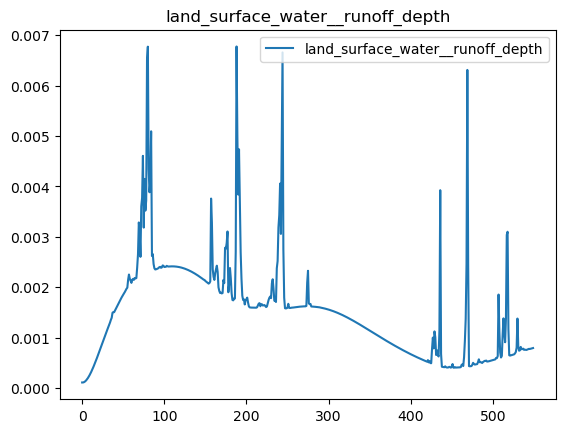

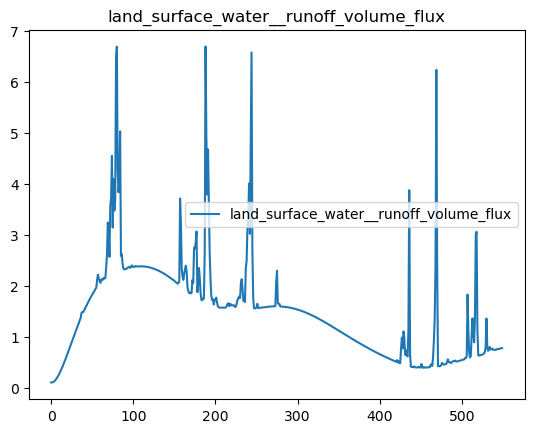

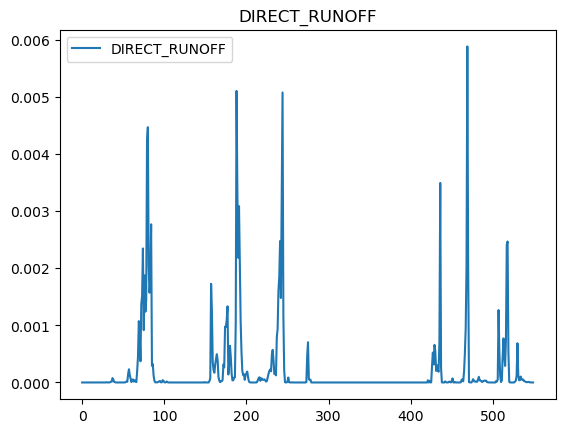

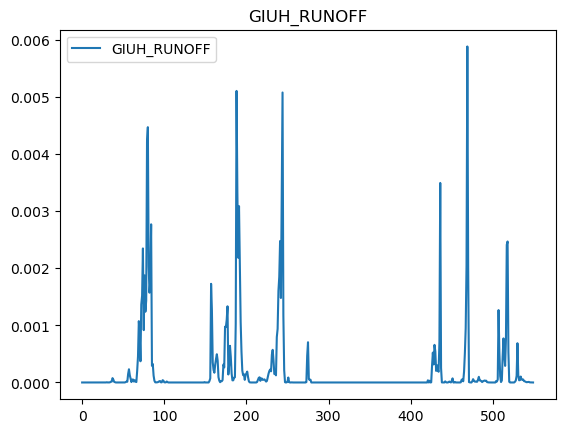

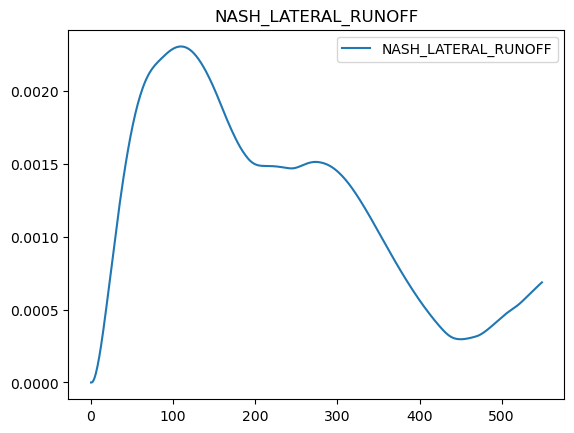

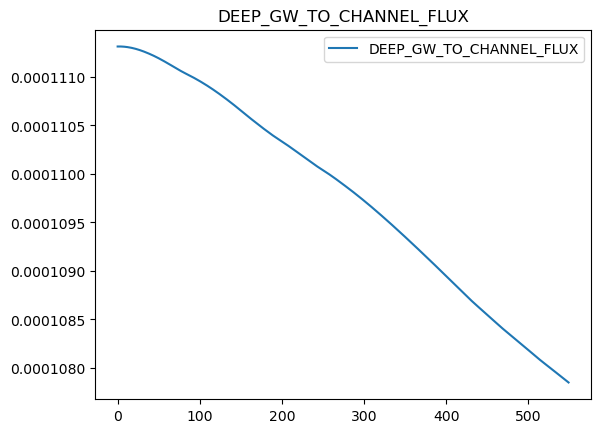

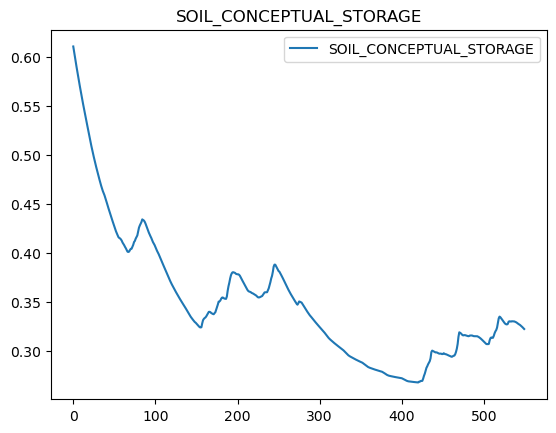

In [79]:
istart_plot = 0
iend_plot = 550
x = list(range(istart_plot, iend_plot))
for output in outputs:
    plt.plot(x, output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()